In [188]:
from clutter_filter import GroundClutterFilter
import numpy as np
import glob, os
# import radarkit
import radarkitIQ as radarkit
import momentgen as mg

In [189]:
# fname = '../data/20240524/RAXPOL-20240524-001922.687.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002125.654.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002338.768.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002543.944.rkc'
# fname = '../data/20240524/RAXPOL-20240524-002604.135.rkc'
# fname = '../data/20250518/RAXPOL-20250518-225404.925.rkc'
fname = '../data/20250518/RAXPOL-20250518-225415.423.rkc'
# fname = '../data/20250518/RAXPOL-20250518-225838.290.rkc'
# fname = '../data/20250518/RAXPOL-20250518-225850.492.rkc'
# fname = '../data/20250518/RAXPOL-20250518-230109.539.rkc'
# fname = '../data/20250518/RAXPOL-20250518-230114.467.rkc'
# fname = '../data/20250605/D1/RAXPOL-20250605-215634.580.rkc'
# fname = '../data/20250605/D2/RAXPOL-20250605-223837.894.rkc' # Morton bad clutter
# fname = '../data/20250605/D2/RAXPOL-20250605-224237.848.rkc'
# fname = '../../../../../Code/Met/DPSD/data/iq/PX1K/PX-20130520-201419-E2.6.iq'
# fname = '../data/20250605/D3/RAXPOL-20250605-230157.216.rkc' # Good looking
# rkid = radarkit.open(fname)
# out = rkid.read()

count = 50 # Pulses per ray
grf = False

rkid = radarkit.rkcfile(fname)
print(rkid.pulses)

Filename: ../data/20250518/RAXPOL-20250518-225415.423.rkc
preface = RadarKit/IQ   buildNo = 8
Pulse data size: 963244608
gateCount = 16587   capacity = 36480   downSampledGateCount = 1659
data offset = 5272
Reading pulses ...
Number of pulses: 36028
[(130667, 156039, 43512111, 3311, 36480, 16587, 1659, 50, 35, 1747608855, 423717, 82455.42700057, [ 23, 252,   0,   0], [  0, 157,   0,   0], 4, 0, 120, 3., 0.8624387, 120.04686 , -0.01098648, 14.908653, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [[[-1.53411055e+04, -2.05663438e+04], [-1.25500127e+04, -1.68118867e+04], [-9.72130371e+03, -1.26286445e+04], ..., [-7.63671875e+00, -2.82617188e+00], [-7.35351562e+00, -3.11132812e+00], [-8.47656250e-01, -3.39355469e+00]], [[-2.59793867e+04, -9.42460156e+03], [-2.08573867e+04, -7.64156152e+

In [190]:
# ciq = out['ciq']

# pulses_new = []
# print(np.array(pulses[0]['iq'][0]))
# for pulse in pulses:
	# pulses_new.append(pulse['iq'])
# pulses = np.array(pulses_new)

pulses = rkid.pulses['iq']
# (pulse, iq, gate, hv)
pulses = pulses.transpose((1,2,3,0))
# (iq, gate, hv, pulse)
pulses = pulses[0,:,:,:] + 1.j*pulses[1,:,:,:]
# (gate, hv, pulse)
pulses = pulses.transpose((0,2,1)).astype(np.complex128)
# (gate, pulse, hv)

# ciq = pulses

# lamb = rkid.desc.wavelength
# prt = radarkit.read_RKFloat_array(rkid.configs.contents.prt,1)
lamb = rkid.header['desc']['wavelength']
prt = rkid.header['config']['prt']
c = 299,792,458
sample_freq = int(rkid.header['waveform']['fs'])
sample_time = 1/sample_freq
va = lamb/(4*prt)
# C = np.abs(radarkit.read_RKComplex_array(rkid.configs.contents.systemZCal, 1)[0])
# l = np.abs(radarkit.read_RKComplex_array(rkid.configs.contents.systemZCal, 2)[1])

totaln = pulses.shape[1]
rayCount = int(np.floor(totaln/count)) # Rays per sweep
gateCount = pulses.shape[0]
n = rayCount * count

az = rkid.pulses['azimuthDegrees']
el = rkid.pulses['elevationDegrees']

# # he's expecting ciq to be in (pulse, h/v, range)
# X_h = np.reshape(ciq[:n, 0, :], (rayCount, count, -1))
# # transpose (ray, pulse, range(?)) to (range, ray, pulse)
# X_h = np.transpose(X_h, (2, 0, 1))

# X_v = np.reshape(ciq[:n, 1, :], (rayCount, count, -1))
# X_v = np.transpose(X_v, (2, 0, 1))

X_h = pulses[:,:n,0]
# (gate, pulse)
X_h = np.reshape(X_h, (gateCount, rayCount, count))
# (gate, ray, pulse)

X_v = pulses[:,:n,1]
X_v = np.reshape(X_v, (gateCount, rayCount, count))

az = np.reshape(az[:n], (rayCount, count))
az = az[:,0]
el = np.reshape(el[:n], (rayCount, count))
el = np.nanmean(el, axis=1)


In [191]:
if grf:
	# set some imporatnt radar parameter
	wavelength_scalar = lamb
	# prt_scalar = prt[0]
	num_samples_actual = X_h.shape[2]

	#filter the I/Q time series for the horizontal and vertical polarizations
	filter_inst = GroundClutterFilter(
		wavelength=lamb,
		scan_rate=1/(count * prt),
		prt=prt,
		num_samples=count
	)

	print("\n--- Filtering X_h (Horizontal Polarization) ---")
	filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h = \
		filter_inst.filter_iq_data(X_h.real, X_h.imag, cnr_db_map=None, apply_interpolation=True)

	filtered_X_h_optimized = filtered_i_h + 1j * filtered_q_h

	del filtered_i_h, filtered_q_h, poly_order_map_h, clutter_i_trend_map_h, clutter_q_trend_map_h, interpolated_spectrum_map_h

	print("\n--- Filtering X_v (Vertical Polarization) ---")
	filtered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v = \
		filter_inst.filter_iq_data(X_v.real, X_v.imag, cnr_db_map=None, apply_interpolation=True)

	filtered_X_v_optimized = filtered_i_v + 1j * filtered_q_v

	del filtered_i_v, filtered_q_v, poly_order_map_v, clutter_i_trend_map_v, clutter_q_trend_map_v, interpolated_spectrum_map_v

	print("\nOptimization complete. Filtered data is in filtered_X_h_optimized and filtered_X_v_optimized.")

In [192]:
noise = rkid.header['config']['noise']
N_h, N_v = noise 
if rkid.header['buildNo'] >= 4:
	if rkid.header['dataType'] == 'raw':
		dr = rkid.header['config']['pulseGateSize']
		# dt = dr * 2 / (c/1e6)
	elif rkid.header['dataType'] == 'compressed':
		dr = rkid.header['desc']['pulseToRayRatio'] * rkid.header['config']['pulseGateSize']
		# dt = dr * 2 / (c/1e6)
	else:
		print("Inconsistency detected. This should not happen.")
		dr = 30.
		# dt = 1./50
else:
	dr = 30.
	# dt = 1./50

# rr = (dr/2) + (np.arange(0,ng,gstep) * dr)

R = np.arange(0, gateCount)*dr
C = rkid.header['config']['ZCal']
Cd = rkid.header['config']['DCal']
Cp = rkid.header['config']['PCal']

if grf:
	moments = mg.get_moments(filtered_X_h_optimized, filtered_X_v_optimized, N_h, N_v, R, va, C, Cd, Cp)
else:
	moments = mg.get_moments(X_h, X_v, N_h, N_v, R, va, C, Cd, Cp)

In [193]:
from raxpolCf import raxpolCf

fname_out_base = fname.split('.rkc')[0]

if grf:
	fname_out = fname_out_base + '-f.nc'
else:
	fname_out = fname_out_base + '.nc'
	

rcf = raxpolCf()
rcf.setVolume()
rcf.setSweep()
rcf.setTime((rkid.pulses['time_tv_sec'][:n:count]).astype(np.float64))
rcf.setRange(R.astype(np.float32))
rcf.setPosition(np.nanmean(rkid.header['desc']['latitude']), np.nanmean(rkid.header['desc']['longitude']))
rcf.setScanningStrategy('ppi')
rcf.setTargetAngle(np.nanmean(rkid.pulses['elevationDegrees']))
rcf.setAzimuth(az)
rcf.setElevation(el)
rcf.setPulseWidthSeconds((rkid.pulses['pulseWidthSampleCount'][:n:count]*sample_time).astype(np.float32))
rcf.setPrtSeconds(np.tile(prt, (rayCount,1)))
rcf.setWavelengthMeters(np.tile(lamb, (rayCount,1)))

# print(np.nanmax(moments['DBZ']))
rcf.setDBZ(moments['DBZ'])
rcf.setVEL(moments['VEL'])
rcf.setWIDTH(moments['WIDTH'])
rcf.setZDR(moments['ZDR'])
rcf.setRHOHV(moments['RHOHV'])
rcf.setPHIDP(moments['PHIDP'], units='degrees')
rcf.setSNRH(moments['SNRH'])
rcf.setSNRV(moments['SNRV'])

rcf.saveToFile(fname_out)

In [194]:
import pyart
import matplotlib.pyplot as plt

In [195]:
si = 0

# Eldorado peak
# xlim = (-4,0)
# ylim = (2,6)
# big
# xlim = (-6, 2)
# ylim = (0, 8)

# Morton cool hook
# xlim = (1,5)
# ylim = (2,6)

# Morton cool hook beeg
# xlim = (0,11)
# ylim = (2,13)

# Eldorado twin tors
# xlim = (0, 4)
# ylim = (4, 8)

# Eldorado due N of radar
# xlim = (-0.5, 0.5)
# ylim = (4, 5)
# xlim = (-1.5, 1.5)
# ylim = (3, 6)

# Arnett zoom
# xlim = (-3.7,-2.7)
# ylim = (1.8,2.8)

# Arnett part 2
# xlim = (-5, 5)
# ylim = (0, 10)

# Texas
xlim = (2, 7)
ylim = (3, 8)

zdr_offset = -5
# ds = -25
interval_splits = 1
velmax = 50

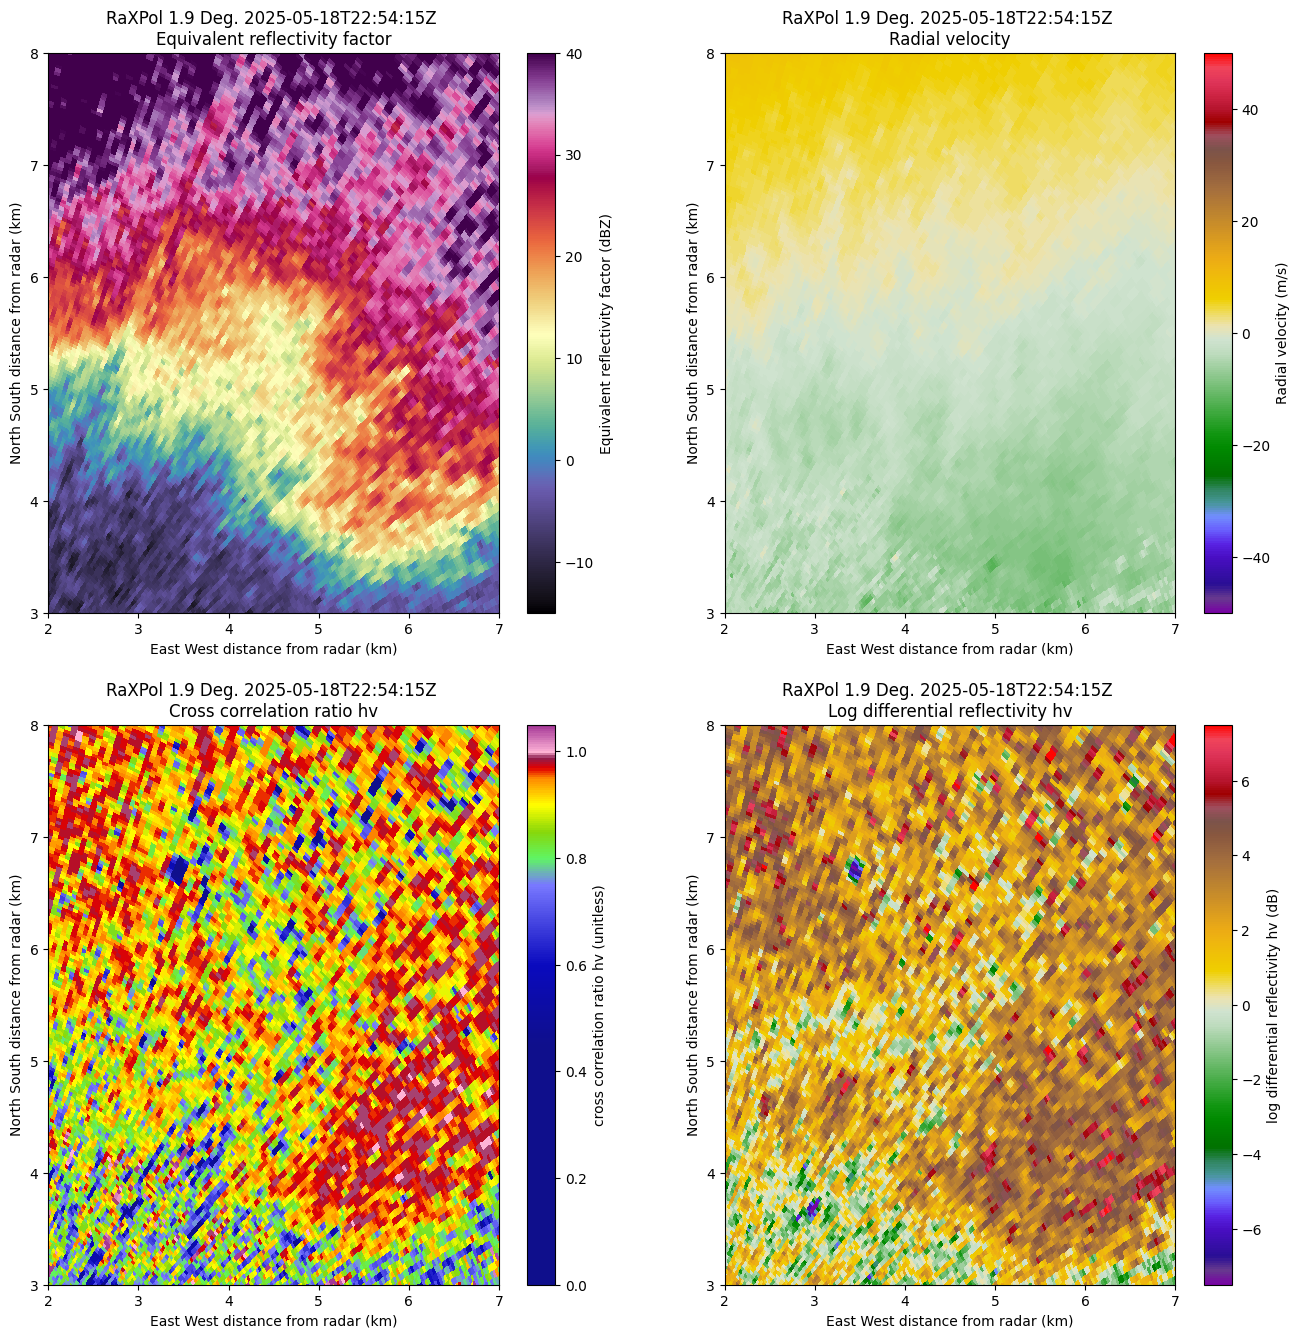

In [196]:
robj = pyart.io.read(fname_out_base + '.nc')
fig, axm = plt.subplots(2,2,figsize=(16,16))
disp = pyart.graph.RadarDisplay(robj)

axm = axm.flatten()

# where = np.where(robj.fields['SNRV']['data'] < ds) # np.where(robj.fields['DBZ']['data'] < -50)
where = np.where(robj.fields['DBZ']['data'] < -50)
robj.fields['VEL']['data'][where] = np.nan
robj.fields['RHOHV']['data'][where] = np.nan
robj.fields['ZDR']['data'][where] = np.nan
robj.fields['WIDTH']['data'][where] = np.nan

robj.fields['ZDR']['data'] = robj.fields['ZDR']['data'] + zdr_offset

robj.add_field('VELD', pyart.correct.dealias_region_based(robj, vel_field='VEL', interval_splits=interval_splits))
# robj.add_field('VELD', pyart.correct.dealias_unwrap_phase(robj, vel_field='VEL', unwrap_unit='ray'))

sweep = robj.get_slice(si)

# zz = u.get_heights(robj.range['data'], robj.elevation['data'][sweep])
# xx, yy = u.get_xxyy(robj.azimuth['data'][sweep], robj.range['data'], robj.elevation['data'][sweep])



# heights = np.arange(0, 500, 10)
# con = ax.contour(xx/1e3, yy/1e3, zz, heights, linewidth=0.5, colors='k')
# ax.clabel(con)
# print(robj.elevation['data'][sweep])

# print(robj.fields.keys())
# dict_keys(['DBZ', 'DBZ1', 'ZDR', 'VEL', 'VELV', 'VELH', 'WIDTH', 'PHIDP', 'KDP', 'RHOHV', 'DBMHC', 'DBMVC', 'SNRHC', 'SNRVC', 'NCP', 'BMHGHT', 'DBZC', 'ZDRC'])

ax = axm[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['DBZ']['standard_name'] = 'Equivalent reflectivity factor'
# disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-25, vmax=85)
disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-15, vmax=40)

ax = axm[1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['VELD']['standard_name'] = 'Radial velocity'
robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('VELD', si, cmap='Carbone42', ax=ax, vmin=-velmax, vmax=velmax)

ax = axm[2]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
# disp.plot_ppi('RHOHV', si, cmap='ChaseSpectral', ax=ax, vmin=0, vmax=1)
disp.plot_ppi('RHOHV', si, cmap='NWS_CC', ax=ax, vmin=0, vmax=1.05)

ax = axm[3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
disp.plot_ppi('ZDR', si, cmap='Carbone42', ax=ax, vmin=-7.5, vmax=7.5)

# ax = axm[3]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# disp.plot_ppi('WIDTH', si, cmap='plasma', ax=ax, vmin=0, vmax=20)

In [197]:
robj = pyart.io.read(fname_out_base + '-f.nc')
fig, axm = plt.subplots(2,2,figsize=(16,16))
disp = pyart.graph.RadarDisplay(robj)

axm = axm.flatten()

where = np.where(robj.fields['DBZ']['data'] < -50)
robj.fields['VEL']['data'][where] = np.nan
robj.fields['RHOHV']['data'][where] = np.nan
robj.fields['ZDR']['data'][where] = np.nan
robj.fields['WIDTH']['data'][where] = np.nan

robj.fields['ZDR']['data'] = robj.fields['ZDR']['data'] + zdr_offset

robj.add_field('VELD', pyart.correct.dealias_region_based(robj, vel_field='VEL', interval_splits=interval_splits))
# robj.add_field('VELD', pyart.correct.dealias_unwrap_phase(robj, vel_field='VEL', unwrap_unit='ray'))

sweep = robj.get_slice(si)

# zz = u.get_heights(robj.range['data'], robj.elevation['data'][sweep])
# xx, yy = u.get_xxyy(robj.azimuth['data'][sweep], robj.range['data'], robj.elevation['data'][sweep])



# heights = np.arange(0, 500, 10)
# con = ax.contour(xx/1e3, yy/1e3, zz, heights, linewidth=0.5, colors='k')
# ax.clabel(con)
# print(robj.elevation['data'][sweep])

# print(robj.fields.keys())
# dict_keys(['DBZ', 'DBZ1', 'ZDR', 'VEL', 'VELV', 'VELH', 'WIDTH', 'PHIDP', 'KDP', 'RHOHV', 'DBMHC', 'DBMVC', 'SNRHC', 'SNRVC', 'NCP', 'BMHGHT', 'DBZC', 'ZDRC'])

ax = axm[0]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['DBZ']['standard_name'] = 'Equivalent reflectivity factor'
# disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-25, vmax=85)
disp.plot_ppi('DBZ', si, cmap='ChaseSpectral', ax=ax, vmin=-15, vmax=40)

ax = axm[1]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
robj.fields['VELD']['standard_name'] = 'Radial velocity'
robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('VELD', si, cmap='Carbone42', ax=ax, vmin=-velmax, vmax=velmax)

# ax = axm[1]
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# robj.fields['DBZDR'] = robj.fields['DBZ'].copy()
# robj.fields['DBZDR']['data'] = np.multiply(robj.fields['DBZDR']['data'], robj.fields['ZDR']['data'])
# robj.fields['DBZDR']['standard_name'] = '10log(h^h/v^h)'
# robj.fields['DBZDR']['units'] = ''
# disp.plot_ppi('DBZDR', si, cmap='Carbone42', ax=ax, vmin=-75, vmax=75)

ax = axm[2]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
# disp.plot_ppi('RHOHV', si, cmap='ChaseSpectral', ax=ax, vmin=0, vmax=1)
disp.plot_ppi('RHOHV', si, cmap='NWS_CC', ax=ax, vmin=0, vmax=1.05)

ax = axm[3]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# robj.fields['VELD']['standard_name'] = 'Radial velocity'
# robj.fields['VELD']['units'] = 'm/s'
disp.plot_ppi('ZDR', si, cmap='Carbone42', ax=ax, vmin=-7.5, vmax=7.5)

FileNotFoundError: [Errno 2] No such file or directory: '../data/20250518/RAXPOL-20250518-225415.423-f.nc'